In [ ]:
! python -m pip install vllm

: 

In [1]:
! vllm --version

INFO 04-16 17:53:17 [__init__.py:260] No platform detected, vLLM is running on UnspecifiedPlatform
0.8.1


In [5]:
import requests

response = requests.post("http://localhost:8000/v1/chat/completions", json={
    "model": "Qwen/Qwen2.5-Coder-32B-Instruct",
    "messages": [
        {"role": "user", "content": "Explain semaphores in operating systems with examples."}
    ],
    "max_tokens": 100,
    "temperature": 0.7
})

print(response.json())


{'id': 'chatcmpl-4f2eed9523934552adcbe1a4e7bbbf9c', 'object': 'chat.completion', 'created': 1744849885, 'model': 'Qwen/Qwen2.5-Coder-32B-Instruct', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'reasoning_content': None, 'content': 'Certainly! Semaphores are synchronization primitives used in operating systems to control access to shared resources by multiple processes or threads. They help prevent race conditions and ensure that only a limited number of processes can access a resource at the same time.\n\n### Types of Semaphores\n\n1. **Binary Semaphore (Mutex):**\n   - Can have only two states: 0 and 1.\n   - Used for mutual exclusion.\n   - Only one process can hold the semaphore at any given time.\n\n2.', 'tool_calls': []}, 'logprobs': None, 'finish_reason': 'length', 'stop_reason': None}], 'usage': {'prompt_tokens': 40, 'total_tokens': 140, 'completion_tokens': 100, 'prompt_tokens_details': None}, 'prompt_logprobs': None}


In [12]:
from openai import OpenAI
import os

# Initialize the OpenAI client with your API key
client = OpenAI(api_key="token123", base_url="http://localhost:8000/v1")

# Define the messages for the chat
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Hello, how are you?"}
]

# Create a chat completion with streaming enabled
response = client.chat.completions.create(
    model="Qwen/Qwen2.5-Coder-32B-Instruct",
    messages=messages,
    stream=True
)

# Stream and print the response chunks
for chunk in response:
    if chunk.choices and chunk.choices[0].delta and chunk.choices[0].delta.content:
        print(chunk.choices[0].delta.content, end='', flush=True)


Hello! I'm just a computer program, so I don't have feelings, but thanks for asking. How can I assist you today?

In [ ]:
from vllm import LLM, SamplingParams

# Define your list of prompts
prompts = [
    "Write a hello world program in C.",
    "Explain the concept of polymorphism in object-oriented programming.",
    "What are the benefits of using a version control system?"
]

# Set the sampling parameters
sampling_params = SamplingParams(temperature=0.7, top_p=0.9, max_tokens=100)

# Initialize the LLM with your chosen model
llm = LLM(model="Qwen/Qwen2.5-Coder-32B-Instruct")  # Replace with your desired model

# Generate outputs for the batch of prompts
outputs = llm.generate(prompts, sampling_params)

# Display the results
for output in outputs:
    print(f"Prompt: {output.prompt}")
    print(f"Generated Text: {output.outputs[0].text}\n")


In [15]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 64.0 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.5 MB/s eta 0:00:00


Testing with 50 prompts...

Running sequential processing...
Estimated sequential time for all prompts: 3587.18 seconds
Sequential processing would take too long. Skipping full sequential test.

Running concurrent processing with 5 workers...

Running batched processing with batch size 1...
Error: Received status code 401
{"error":"Unauthorized"}
Error: Received status code 401
{"error":"Unauthorized"}
Error: Received status code 401
{"error":"Unauthorized"}
Error: Received status code 401
{"error":"Unauthorized"}
Error: Received status code 401
{"error":"Unauthorized"}
Error: Received status code 401
{"error":"Unauthorized"}
Error: Received status code 401
{"error":"Unauthorized"}
Error: Received status code 401
{"error":"Unauthorized"}
Error: Received status code 401
{"error":"Unauthorized"}
Error: Received status code 401
{"error":"Unauthorized"}
Error: Received status code 401
{"error":"Unauthorized"}
Error: Received status code 401
{"error":"Unauthorized"}
Error: Received status c

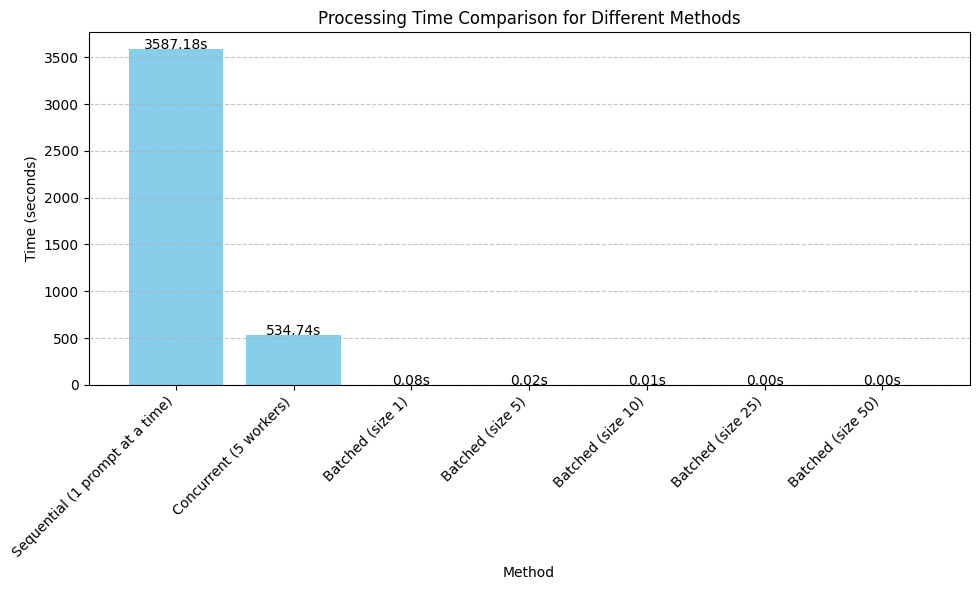


Speedup compared to sequential processing:
Concurrent (5 workers): 6.71x faster
Batched (size 1): 46864.14x faster
Batched (size 5): 230805.26x faster
Batched (size 10): 611118.33x faster
Batched (size 25): 1517012.83x faster
Batched (size 50): 3009146.64x faster


In [16]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
import concurrent.futures
import requests
import numpy as np

# Settings
BASE_URL = "http://localhost:8000/v1"
MODEL_NAME = "Qwen/Qwen2.5-Coder-32B-Instruct"
API_KEY = "token123"  # Your API key
NUM_PROMPTS = 50  # Number of prompts to test
BATCH_SIZES = [1, 5, 10, 25, 50]  # Different batch sizes to test

# Initialize the OpenAI client
client = OpenAI(api_key=API_KEY, base_url=BASE_URL)

# Generate similar but slightly different prompts
def generate_prompts(num_prompts):
    topics = ["Python", "JavaScript", "SQL", "Docker", "Kubernetes", 
              "Machine Learning", "Data Science", "Web Development", 
              "APIs", "Cloud Computing"]
    
    prompts = []
    for i in range(num_prompts):
        topic = topics[i % len(topics)]
        prompts.append(f"Explain {topic} concepts to a beginner in 3 sentences. Include example #{i+1}.")
    
    return prompts

# Method 1: Sequential processing - one request at a time
def run_sequential(prompts):
    start_time = time.time()
    results = []
    
    for prompt in prompts:
        try:
            response = client.chat.completions.create(
                model=MODEL_NAME,
                messages=[
                    {"role": "user", "content": prompt}
                ],
                max_tokens=150,
                temperature=0.7
            )
            results.append(response.choices[0].message.content)
        except Exception as e:
            print(f"Error with prompt: {prompt}")
            print(f"Error: {e}")
            results.append(None)
    
    end_time = time.time()
    return results, end_time - start_time

# Method 2: Using direct API with batching
def run_batched(prompts, batch_size):
    start_time = time.time()
    results = []
    
    for i in range(0, len(prompts), batch_size):
        batch = prompts[i:i+batch_size]
        requests_data = []
        
        for prompt in batch:
            requests_data.append({
                "role": "user",
                "content": prompt
            })
            
        try:
            response = requests.post(
                f"{BASE_URL}/chat/completions", 
                json={
                    "model": MODEL_NAME,
                    "messages": [{"role": "system", "content": "You are a helpful assistant."}] + 
                               [{"role": "user", "content": prompt} for prompt in batch],
                    "max_tokens": 150,
                    "temperature": 0.7
                }
            )
            
            if response.status_code == 200:
                response_data = response.json()
                # Extract responses based on the API response structure
                for choice in response_data.get('choices', []):
                    results.append(choice.get('message', {}).get('content'))
            else:
                print(f"Error: Received status code {response.status_code}")
                print(response.text)
                results.extend([None] * len(batch))
                
        except Exception as e:
            print(f"Error with batch: {e}")
            results.extend([None] * len(batch))
    
    end_time = time.time()
    return results, end_time - start_time

# Method 3: Concurrent processing (for comparison)
def run_concurrent(prompts, max_workers=5):
    start_time = time.time()
    results = [None] * len(prompts)
    
    def process_single(idx, prompt):
        try:
            response = client.chat.completions.create(
                model=MODEL_NAME,
                messages=[
                    {"role": "user", "content": prompt}
                ],
                max_tokens=150,
                temperature=0.7
            )
            return idx, response.choices[0].message.content
        except Exception as e:
            print(f"Error with prompt {idx}: {e}")
            return idx, None
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_single, i, prompt): i for i, prompt in enumerate(prompts)}
        for future in concurrent.futures.as_completed(futures):
            idx, result = future.result()
            results[idx] = result
    
    end_time = time.time()
    return results, end_time - start_time

# Run the tests
def run_comparison():
    prompts = generate_prompts(NUM_PROMPTS)
    results = {}
    
    print(f"Testing with {NUM_PROMPTS} prompts...")
    
    # Test sequential
    print("\nRunning sequential processing...")
    _, sequential_time = run_sequential(prompts[:10])  # Run on a smaller subset first to estimate time
    estimated_sequential_time = sequential_time * (NUM_PROMPTS / 10)
    print(f"Estimated sequential time for all prompts: {estimated_sequential_time:.2f} seconds")
    
    if estimated_sequential_time > 300:  # If estimated time > 5 minutes
        print("Sequential processing would take too long. Skipping full sequential test.")
        results['Sequential (1 prompt at a time)'] = estimated_sequential_time
    else:
        _, sequential_time = run_sequential(prompts)
        results['Sequential (1 prompt at a time)'] = sequential_time
    
    # Test concurrent
    print("\nRunning concurrent processing with 5 workers...")
    _, concurrent_time = run_concurrent(prompts, max_workers=5)
    results['Concurrent (5 workers)'] = concurrent_time
    
    # Test different batch sizes
    for batch_size in BATCH_SIZES:
        if batch_size <= NUM_PROMPTS:
            print(f"\nRunning batched processing with batch size {batch_size}...")
            _, batch_time = run_batched(prompts, batch_size)
            results[f'Batched (size {batch_size})'] = batch_time
    
    # Results
    df = pd.DataFrame(list(results.items()), columns=['Method', 'Time (seconds)'])
    print("\nResults:")
    print(df)
    
    # Visualize
    plt.figure(figsize=(10, 6))
    plt.bar(df['Method'], df['Time (seconds)'], color='skyblue')
    plt.title('Processing Time Comparison for Different Methods')
    plt.ylabel('Time (seconds)')
    plt.xlabel('Method')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    for i, v in enumerate(df['Time (seconds)']):
        plt.text(i, v + 0.5, f'{v:.2f}s', ha='center')
    
    plt.show()
    
    # Calculate speedup
    baseline = results['Sequential (1 prompt at a time)']
    speedups = {method: baseline/time for method, time in results.items()}
    
    print("\nSpeedup compared to sequential processing:")
    for method, speedup in speedups.items():
        if method != 'Sequential (1 prompt at a time)':
            print(f"{method}: {speedup:.2f}x faster")
    
    return results

# Run the experiment
if __name__ == "__main__":
    run_comparison()

In [17]:
from openai import OpenAI
import time

# Settings
BASE_URL = "http://localhost:8000/v1"
MODEL_NAME = "Qwen/Qwen2.5-Coder-32B-Instruct"
API_KEY = "token123"  # Your API key
BATCH_SIZE = 3  # Small batch size to test

# Initialize the OpenAI client
client = OpenAI(api_key=API_KEY, base_url=BASE_URL)

# Generate a few test prompts
def generate_test_prompts(num_prompts=5):
    topics = ["Python", "JavaScript", "SQL", "Docker", "Kubernetes"]
    return [f"Explain {topics[i]} concepts to a beginner in 3 sentences." for i in range(num_prompts)]

# Batch processing test
def test_batching(prompts, batch_size):
    print(f"\n===== TESTING BATCHED PROCESSING (batch size: {batch_size}) =====")
    start_time = time.time()
    batch_count = 0
    
    # Process prompts in batches
    for i in range(0, len(prompts), batch_size):
        batch_count += 1
        batch = prompts[i:i+batch_size]
        print(f"\nProcessing batch {batch_count} with {len(batch)} prompts")
        batch_start = time.time()
        
        # Process each prompt in the batch concurrently
        responses = []
        for j, prompt in enumerate(batch):
            print(f"  Submitting prompt {i+j+1}/{len(prompts)}: {prompt}")
            response = client.chat.completions.create(
                model=MODEL_NAME,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=150,
                temperature=0.7,
                stream=False
            )
            responses.append(response)
        
        # Process the responses
        for j, response in enumerate(responses):
            print(f"  Response {j+1}: {response.choices[0].message.content[:50]}...")
        
        batch_time = time.time() - batch_start
        print(f"Batch {batch_count} time: {batch_time:.2f} seconds")
    
    total_time = time.time() - start_time
    print(f"\nTotal batched time: {total_time:.2f} seconds")
    return total_time

# Run the test
prompts = generate_test_prompts(5)  # Generate 5 test prompts
batched_time = test_batching(prompts, BATCH_SIZE)
print(f"Completed batch processing in {batched_time:.2f} seconds")


===== TESTING BATCHED PROCESSING (batch size: 3) =====

Processing batch 1 with 3 prompts
  Submitting prompt 1/5: Explain Python concepts to a beginner in 3 sentences.
  Submitting prompt 2/5: Explain JavaScript concepts to a beginner in 3 sentences.
  Submitting prompt 3/5: Explain SQL concepts to a beginner in 3 sentences.
  Response 1: Python is a versatile programming language known f...
  Response 2: JavaScript is a programming language that allows y...
  Response 3: SQL (Structured Query Language) is a programming l...
Batch 1 time: 126.14 seconds

Processing batch 2 with 2 prompts
  Submitting prompt 4/5: Explain Docker concepts to a beginner in 3 sentences.
  Submitting prompt 5/5: Explain Kubernetes concepts to a beginner in 3 sentences.
  Response 1: Docker is a platform that allows you to package ap...
  Response 2: Kubernetes is an open-source platform that automat...
Batch 2 time: 77.90 seconds

Total batched time: 204.04 seconds
Completed batch processing in 204.04 seco

In [18]:
import threading
from openai import OpenAI
import time

# Settings
BASE_URL = "http://localhost:8000/v1"
MODEL_NAME = "Qwen/Qwen2.5-Coder-32B-Instruct"
API_KEY = "token123"  # Your API key

# Initialize the OpenAI client
client = OpenAI(api_key=API_KEY, base_url=BASE_URL)

# Function to process a single prompt
def process_prompt(prompt, index, results):
    try:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=150,
            temperature=0.7,
            stream=False
        )
        results[index] = response.choices[0].message.content
        print(f"Completed prompt {index+1}: {results[index][:50]}...")
    except Exception as e:
        print(f"Error processing prompt {index+1}: {e}")
        results[index] = f"Error: {str(e)}"

# Test concurrent processing (allows vLLM to batch internally)
def test_concurrent_requests(prompts):
    print("\n===== TESTING CONCURRENT REQUESTS =====")
    start_time = time.time()
    
    threads = []
    results = [None] * len(prompts)
    
    # Start all requests concurrently
    for i, prompt in enumerate(prompts):
        print(f"Starting thread for prompt {i+1}: {prompt}")
        thread = threading.Thread(target=process_prompt, args=(prompt, i, results))
        threads.append(thread)
        thread.start()
    
    # Wait for all threads to complete
    for thread in threads:
        thread.join()
    
    total_time = time.time() - start_time
    print(f"\nTotal concurrent processing time: {total_time:.2f} seconds")
    return total_time, results

# Generate prompts and run the test
prompts = generate_test_prompts(5)
concurrent_time, results = test_concurrent_requests(prompts)
print(f"Completed concurrent processing in {concurrent_time:.2f} seconds")


===== TESTING CONCURRENT REQUESTS =====
Starting thread for prompt 1: Explain Python concepts to a beginner in 3 sentences.
Starting thread for prompt 2: Explain JavaScript concepts to a beginner in 3 sentences.
Starting thread for prompt 3: Explain SQL concepts to a beginner in 3 sentences.
Starting thread for prompt 4: Explain Docker concepts to a beginner in 3 sentences.
Starting thread for prompt 5: Explain Kubernetes concepts to a beginner in 3 sentences.
Completed prompt 3: SQL, or Structured Query Language, is a programmin...
Completed prompt 5: Kubernetes is an open-source platform designed to ...Completed prompt 2: JavaScript is a programming language that allows y...

Completed prompt 1: Python is a versatile programming language known f...
Completed prompt 4: Docker is a platform that allows you to package ap...

Total concurrent processing time: 161.35 seconds
Completed concurrent processing in 161.35 seconds


In [ ]:
import threading
from openai import OpenAI
import time
import matplotlib.pyplot as plt

# Settings
BASE_URL = "http://localhost:8000/v1"
MODEL_NAME = "Qwen/Qwen2.5-Coder-32B-Instruct"
API_KEY = "token123"
BATCH_SIZES = [250, 500, 1000, 2000]  # Updated batch sizes

# Initialize OpenAI client
client = OpenAI(api_key=API_KEY, base_url=BASE_URL)

# Generate test prompts
def generate_test_prompts(num_prompts):
    topics = ["Python", "JavaScript", "SQL", "Docker", "Kubernetes"]
    return [f"Explain {topics[i % len(topics)]} concepts in 3 sentences. Example #{i+1}." for i in range(num_prompts)]

# Process a single prompt
def process_prompt(prompt, index, results):
    try:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=150,
            temperature=0.7,
            stream=False
        )
        results[index] = response.choices[0].message.content
    except Exception as e:
        print(f"Error processing prompt {index+1}: {e}")
        results[index] = f"Error: {str(e)}"

# Run one batch per batch size
def quick_batch_test():
    times = []
    
    for batch_size in BATCH_SIZES:
        print(f"Testing batch size {batch_size}...")
        prompts = generate_test_prompts(batch_size)
        results = [None] * batch_size
        
        start_time = time.time()
        
        threads = []
        for i, prompt in enumerate(prompts):
            thread = threading.Thread(target=process_prompt, args=(prompt, i, results))
            threads.append(thread)
            thread.start()
        
        for thread in threads:
            thread.join()
        
        total_time = time.time() - start_time
        times.append(total_time)
        print(f"Batch size {batch_size} completed in {total_time:.2f} seconds")
    
    # Calculate throughput
    throughputs = [size / time for size, time in zip(BATCH_SIZES, times)]
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(BATCH_SIZES)), times)
    plt.xlabel('Batch Size')
    plt.ylabel('Total Time (seconds)')
    plt.title('Single Batch Processing Time by Batch Size')
    plt.xticks(range(len(BATCH_SIZES)), BATCH_SIZES)
    
    for i, v in enumerate(times):
        plt.text(i, v + 0.3, f'{v:.2f}s', ha='center')
    
    plt.savefig('batch_comparison.png')
    plt.show()
    
    # Print results
    print("\nResults:")
    print("Batch Size | Time (s) | Prompts/second")
    print("-" * 40)
    for i, size in enumerate(BATCH_SIZES):
        print(f"{size:^10} | {times[i]:^8.2f} | {throughputs[i]:^8.2f}")
    
    # Find optimal batch size
    optimal_idx = throughputs.index(max(throughputs))
    print(f"\nOptimal batch size: {BATCH_SIZES[optimal_idx]}")

# Run the test
quick_batch_test()


Testing batch size 250...
Batch size 250 completed in 219.14 seconds
Testing batch size 500...
Batch size 500 completed in 429.24 seconds
Testing batch size 1000...
Batch size 1000 completed in 957.87 seconds
Testing batch size 2000...


KeyboardInterrupt: 

Error processing prompt 738: Connection error.
Error processing prompt 727: Connection error.
Error processing prompt 650: Connection error.
Error processing prompt 861: Connection error.
Error processing prompt 913: Connection error.
Error processing prompt 800: Connection error.
Error processing prompt 839: Connection error.
Error processing prompt 777: Connection error.
Error processing prompt 682: Connection error.
Error processing prompt 752: Connection error.
Error processing prompt 924: Connection error.
Error processing prompt 743: Connection error.
Error processing prompt 878: Connection error.
Error processing prompt 994: Connection error.
Error processing prompt 691: Connection error.
Error processing prompt 940: Connection error.
Error processing prompt 741: Connection error.
Error processing prompt 776: Connection error.
Error processing prompt 699: Connection error.
Error processing prompt 664: Connection error.
Error processing prompt 794: Connection error.
Error process